# Example Burgers' equation

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [1]:
import matplotlib.pyplot as plt

# General imports
import numpy as np
import torch

# DeePyMoD imports
from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.data.burgers import burgers_delta
from deepymod.model.constraint import LeastSquares
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.sparse_estimators import Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import Periodic, TrainTest, TrainTestPeriodic

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


# Dataset
Create all the argument we need to create a Burgers dataset:

In [2]:
# Making dataset
v = 0.1
A = 1.0

x = torch.linspace(-3, 4, 100)
t = torch.linspace(0.5, 5.0, 50)
load_kwargs = {"x": x, "t": t, "v": v, "A": A}
preprocess_kwargs = {"noise_level": 0.05}

Then we pass this function to the dataset class, which then adds noise to it, normalizes the coordinates and performs random subsampling to it.

In [3]:
dataset = Dataset(
    burgers_delta,
    load_kwargs=load_kwargs,
    preprocess_kwargs=preprocess_kwargs,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 500},
    device=device,
)

Dataset is using device:  cuda


Let's plot it to get an idea of the data. As we can see, $X$ has 2 dimensions, $\{x, t\}$, while $y$ has only one, $\{u\}$. Always explicity set the shape (i.e. $N\times 1$, not $N$) or you'll get errors. We also added 5% of noise.

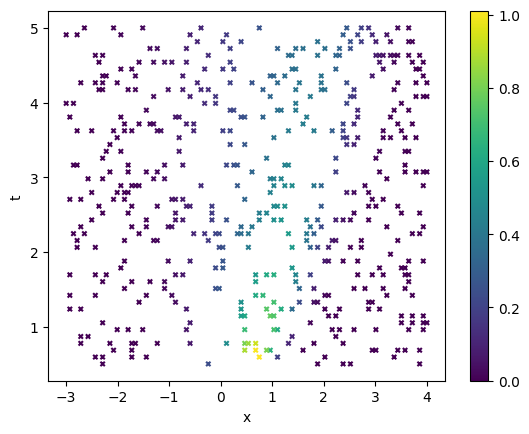

In [4]:
coords = dataset.get_coords().cpu()
data = dataset.get_data().cpu()
fig, ax = plt.subplots()
im = ax.scatter(coords[:,1], coords[:,0], c=data[:,0], marker="x", s=10)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)

plt.show()

We now also wish to split the data into a train and test split, specifically into loaders, which handle the logic of passing the samples to the model.

In [5]:
train_dataloader, test_dataloader = get_train_test_loader(
    dataset, train_test_split=0.8
)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [6]:
network = NN(2, [50, 50, 50,50], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [7]:
library = Library1D(poly_order=2, diff_order=3) 

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [8]:
estimator = Threshold(0.1) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5) 

Configuration of the sparsity estimator 

In [9]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and send it to the GPU and select the optimizer 

In [10]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) 


## Run DeepMoD 

We can now run DeepMoD using all the options we have set, the training and test loaders:
* The directory where the tensorboard file is written (log_dir)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [11]:
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    exp_ID="Test",
    write_iterations=25,
    max_iterations=100000,
    delta=1e-4,
    patience=200,
)

 11650  MSE: 2.47e-06  Reg: 4.33e-06  L1: 1.95e+00 Algorithm converged. Writing model to disk.


Sparsity masks provide the active and non-active terms in the PDE:

In [12]:
model.sparsity_masks

[tensor([False, False,  True, False, False,  True, False, False, False, False,
         False, False], device='cuda:0')]

estimatior_coeffs gives the magnitude of the active terms:

In [13]:
print(model.estimator_coeffs())

[array([[ 0.        ],
       [ 0.        ],
       [ 0.79008245],
       [ 0.        ],
       [ 0.        ],
       [-1.1256975 ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)]


So the final terms that remain are the $u_{xx}$ and $u u_{x}$ resulting in the following Burgers equation (in normalized coefficients: 
$u_t = 0.4 u_{xx} - u u_{x}$.

In [14]:
print(model.constraint_coeffs())

[tensor([[ 0.0000],
        [ 0.0000],
        [ 0.0980],
        [ 0.0000],
        [ 0.0000],
        [-1.0114],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]


In [15]:
from deepymod.analysis import load_tensorboard

In [16]:
df = load_tensorboard('runs/Nov07_02-13-01_sheshka-ThinkStation-P920Test/')

In [17]:
df.head()

,loss_loss,remaining_MSE_test,loss_mse_output_0,coeffs_output_0_coeff_0,coeffs_output_0_coeff_1,coeffs_output_0_coeff_10,coeffs_output_0_coeff_11,coeffs_output_0_coeff_2,coeffs_output_0_coeff_3,coeffs_output_0_coeff_4,...,unscaled_coeffs_output_0_coeff_10,unscaled_coeffs_output_0_coeff_11,unscaled_coeffs_output_0_coeff_2,unscaled_coeffs_output_0_coeff_3,unscaled_coeffs_output_0_coeff_4,unscaled_coeffs_output_0_coeff_5,unscaled_coeffs_output_0_coeff_6,unscaled_coeffs_output_0_coeff_7,unscaled_coeffs_output_0_coeff_8,unscaled_coeffs_output_0_coeff_9
0,0.046131,0.044675,0.046101,-1.767163,-2.791046,1.064885,-1.072692,-0.800331,-0.289564,2.422191,...,103.135002,-99.446198,-0.783327,-0.260402,0.449098,40.845421,-6.093809,12.934964,-3.145143,-222.650208
25,0.019666,0.024163,0.019404,0.515801,-0.641232,0.773877,-0.561444,-1.144152,-0.820281,-0.692975,...,5.890308,-4.958006,-0.458948,-0.290226,-0.108509,-0.899131,-0.981100,2.848571,-0.580120,5.218228
50,0.016367,0.015931,0.015832,0.223652,-0.611047,0.408560,0.787560,-0.910407,-0.659377,1.046850,...,1.177747,2.877385,-0.343148,-0.216744,0.199717,-2.667380,-0.387348,-0.384537,-1.077088,6.913818
75,0.011704,0.014628,0.011507,0.155376,-0.505216,-1.213128,0.938055,-0.190598,-0.438066,0.479434,...,-3.415152,2.877780,-0.069326,-0.131267,0.088804,-2.088614,1.240703,-0.409927,-0.604243,5.585170
100,0.009402,0.011316,0.009124,0.263308,-0.481400,-1.758919,0.995533,-0.254354,0.217129,-0.825169,...,-3.558512,1.983250,-0.079678,0.050716,-0.164491,-1.029716,1.847689,-0.646083,0.183317,2.930410


In [18]:
df.keys()

Index(['loss_loss', 'remaining_MSE_test', 'loss_mse_output_0',
       'coeffs_output_0_coeff_0', 'coeffs_output_0_coeff_1',
       'coeffs_output_0_coeff_10', 'coeffs_output_0_coeff_11',
       'coeffs_output_0_coeff_2', 'coeffs_output_0_coeff_3',
       'coeffs_output_0_coeff_4', 'coeffs_output_0_coeff_5',
       'coeffs_output_0_coeff_6', 'coeffs_output_0_coeff_7',
       'coeffs_output_0_coeff_8', 'coeffs_output_0_coeff_9',
       'estimator_coeffs_output_0_coeff_0',
       'estimator_coeffs_output_0_coeff_1',
       'estimator_coeffs_output_0_coeff_10',
       'estimator_coeffs_output_0_coeff_11',
       'estimator_coeffs_output_0_coeff_2',
       'estimator_coeffs_output_0_coeff_3',
       'estimator_coeffs_output_0_coeff_4',
       'estimator_coeffs_output_0_coeff_5',
       'estimator_coeffs_output_0_coeff_6',
       'estimator_coeffs_output_0_coeff_7',
       'estimator_coeffs_output_0_coeff_8',
       'estimator_coeffs_output_0_coeff_9', 'loss_l1_output_0',
       'loss_reg_ou

Text(0.5, 1.0, 'Regression')

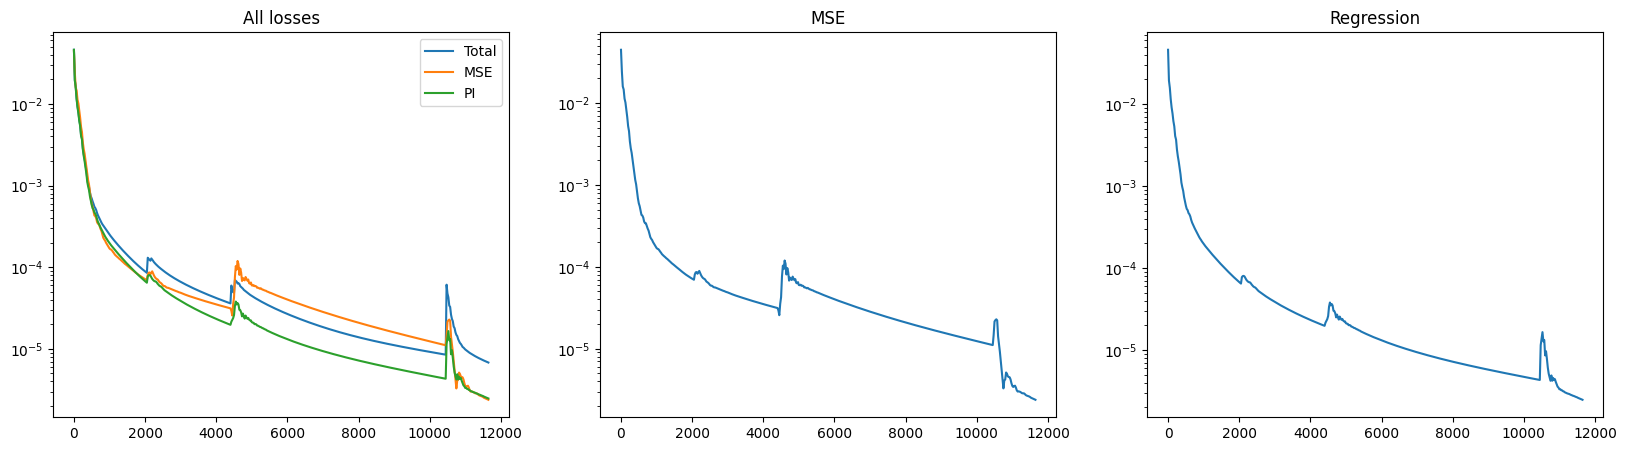

In [22]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.semilogy(df.index, df['loss_loss'], label='Total')
plt.semilogy(df.index, df['remaining_MSE_test'], label='MSE')
plt.semilogy(df.index, df['loss_mse_output_0'], label='PI')
plt.title('All losses')
plt.legend()

plt.subplot(132)
plt.semilogy(df.index, df['remaining_MSE_test'], label='MSE')
plt.title('MSE')

plt.subplot(133)
plt.semilogy(df.index, df['loss_mse_output_0'], label='PI')
plt.title('Regression')

In [23]:
coeff_keys = [key for key in df.keys() if key[:5]=='coeff']
scaled_coeff_keys = [key for key in df.keys() if key[:6]=='scaled']

Text(0.5, 1.0, 'Coefficients')

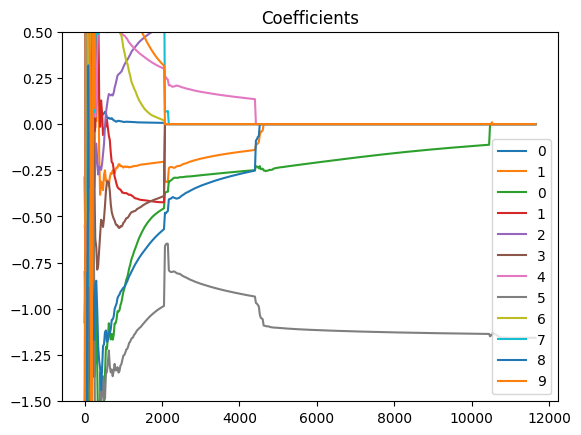

In [24]:
for key in coeff_keys:
    plt.plot(df[key], label=f'{key[-1]}')
plt.legend()
plt.ylim([-1.5, 0.5])
plt.title('Coefficients')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Scaled coefficients')

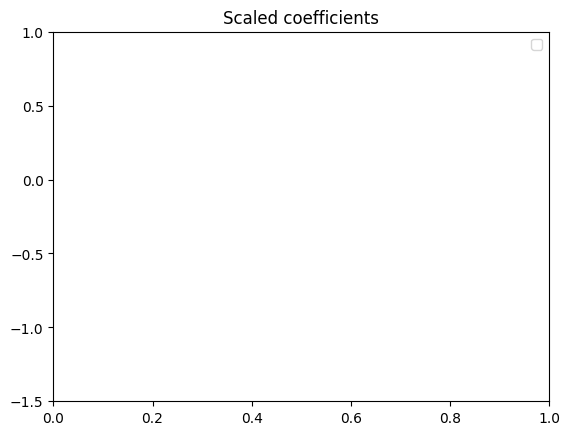

In [25]:
for key in scaled_coeff_keys:
    plt.plot(df[key], label=f'{key[-1]}')
plt.legend()
plt.ylim([-1.5, 1])
plt.title('Scaled coefficients')